## Bank Customer Subscription Prediction

### Problem Description
The goal of this project is to predict whether a bank customer will subscribe to a term deposit based on their demographic and behavioral data. This classification task can assist the bank in identifying potential subscribers, enabling more effective targeting in marketing campaigns and optimizing resource allocation. I will use supervised machine learning techniques to build and evaluate models that predict the binary outcome (yes/no) of subscription.

### Dataset Overview
The dataset used is the Bank Marketing dataset. It contains 41,188 entries with the following features:
- **Numerical Features**: `age`, `duration` (last contact duration in seconds), `campaign` (number of contacts during this campaign), `pdays` (days since last contact from a previous campaign), `previous` (number of contacts before this campaign), `emp.var.rate` (employment variation rate), `cons.price.idx` (consumer price index), `cons.conf.idx` (consumer confidence index), `euribor3m` (Euribor 3-month rate), `nr.employed` (number of employees).
- **Categorical Features**: `job`, `marital`, `education`, `default` (has credit in default), `housing` (has housing loan), `loan` (has personal loan), `contact` (contact type), `month`, `day_of_week`, `poutcome` (outcome of previous campaign).
- **Target Variable**: `y` (yes/no), indicating whether the customer subscribed to a term deposit.

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

path = kagglehub.dataset_download("henriqueyamahata/bank-marketing")
dataset_path = os.path.join(path, 'bank-additional-full.csv')
data = pd.read_csv(dataset_path, sep=';')

print("\nFirst few rows of the dataset:")
print(data.head())
print("\nDataset info:")
print(data.info())


First few rows of the dataset:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.

In [67]:
# Identify numerical and categorical features
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

X = data.drop('y', axis=1)
y = data['y'].map({'yes': 1, 'no': 0})

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

print("Shape of processed data:", X_processed.shape)
print("\nSample of processed data:")
print(X_processed[:5])

Shape of processed data: (41188, 63)

Sample of processed data:
[[ 1.53303429  0.01047142 -0.56592197  0.1954139  -0.34949428  0.64809227
   0.72272247  0.88644656  0.71245988  0.33167991  0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          1.          0.          0.          1.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          1.          0.        ]
 [ 1.62899323 -0.42150051 -0.56592197  0.1954139  -0.34949428  0.64809227
   0.72272247  0.88644656  0.71245988  0.33167991  0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.      

#### Preprocessing Results
The processed data has a shape of (41188, 63) after one-hot encoding the categorical features. For example, `job` with 12 categories expands into multiple columns. Numerical features are standardized to have zero mean and unit variance, ensuring compatibility with machine learning algorithms.

### Exploratory Data Analysis (EDA)
The EDA explores feature distributions and their relationships with the target variable (`y`) to inform model building.

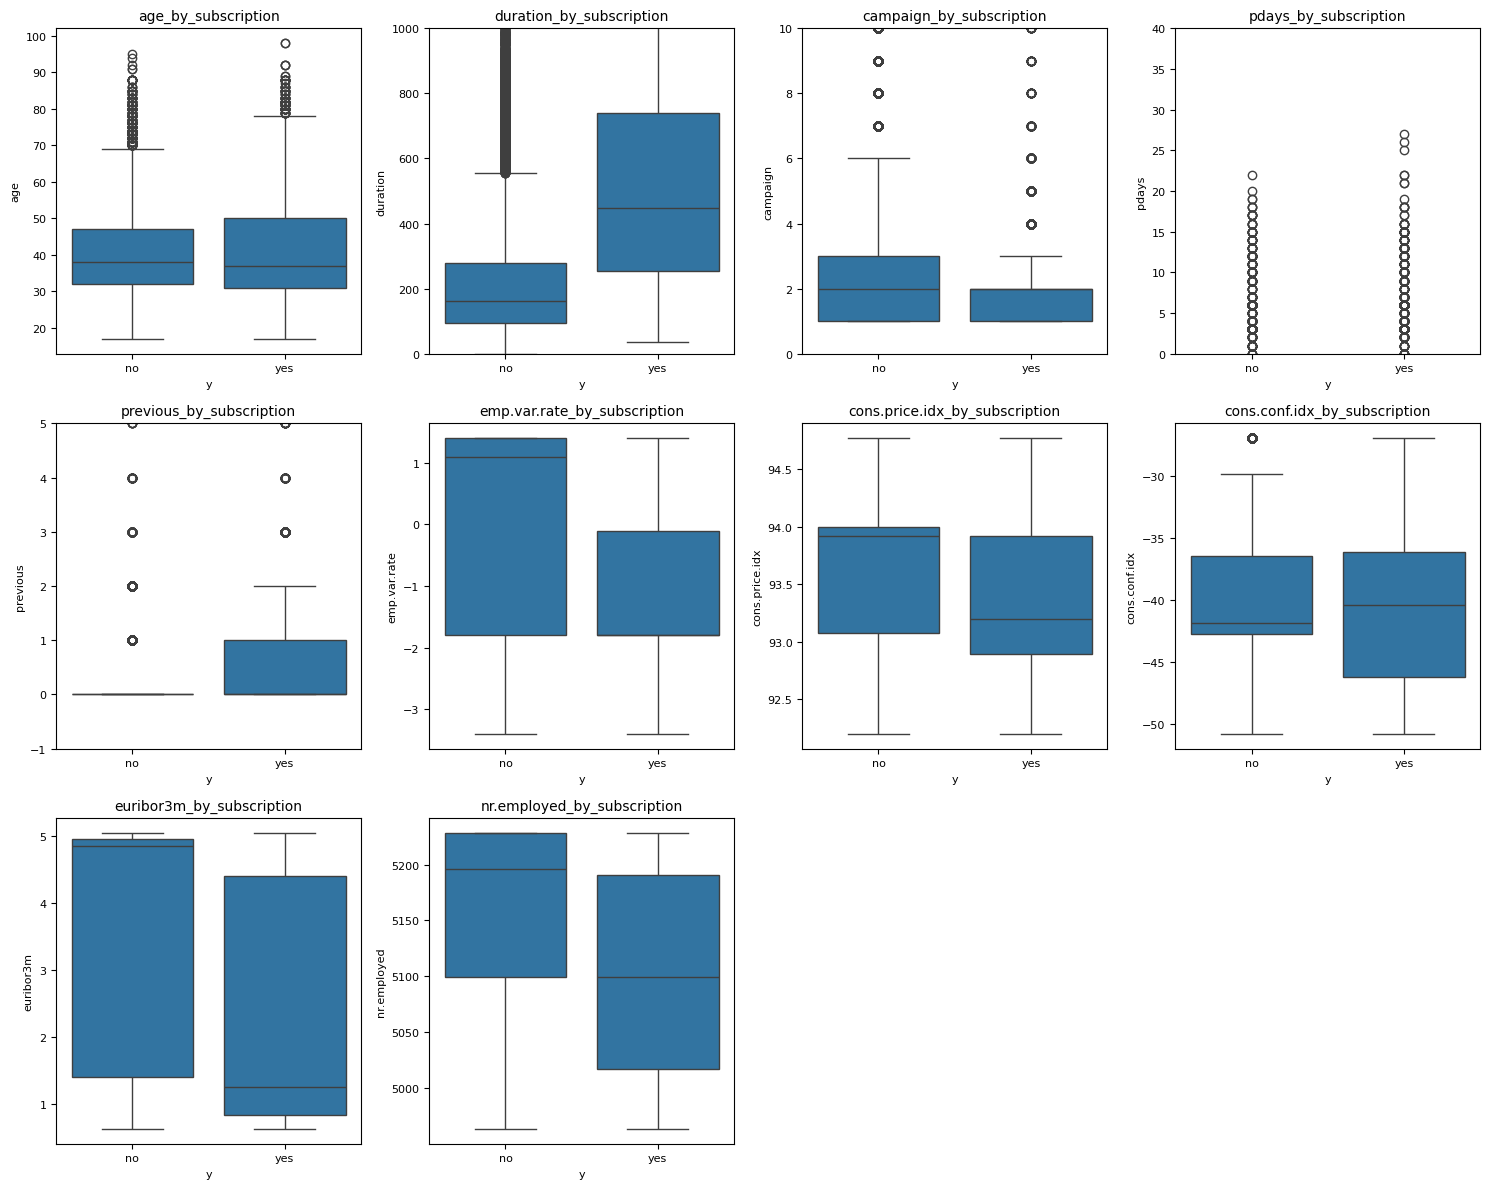

In [68]:
# Box plots for numerical features by target with adjusted scales
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='y', y=col, data=data)
    plt.title(f'{col}_by_subscription', fontsize=10)
    plt.xlabel('y', fontsize=8)
    plt.ylabel(col, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Adjust y-axis limits for specific features to improve readability
    if col == 'duration':
        plt.ylim(0, 1000)
    elif col == 'campaign':
        plt.ylim(0, 10)
    elif col == 'pdays':
        plt.ylim(0, 40)  #999 is a placeholder for "not contacted"
    elif col == 'previous':
        plt.ylim(-1, 5)

plt.tight_layout()
plt.show()

#### Numerical Feature Definitions

- **Age**: Customer age in years.
- **Duration**: Last contact duration seconds.
- **Campaign**: Number of campaign contacts.
- **Pdays**: Days since last contact.
- **Previous**: Prior campaign contacts count.
- **Emp.var.rate**: Employment variation rate percentage.
- **Cons.price.idx**: Consumer price index value.
- **Cons.conf.idx**: Consumer confidence index score.
- **Euribor3m**: Euribor 3-month interest rate.
- **Nr.employed**: Number of employed people.

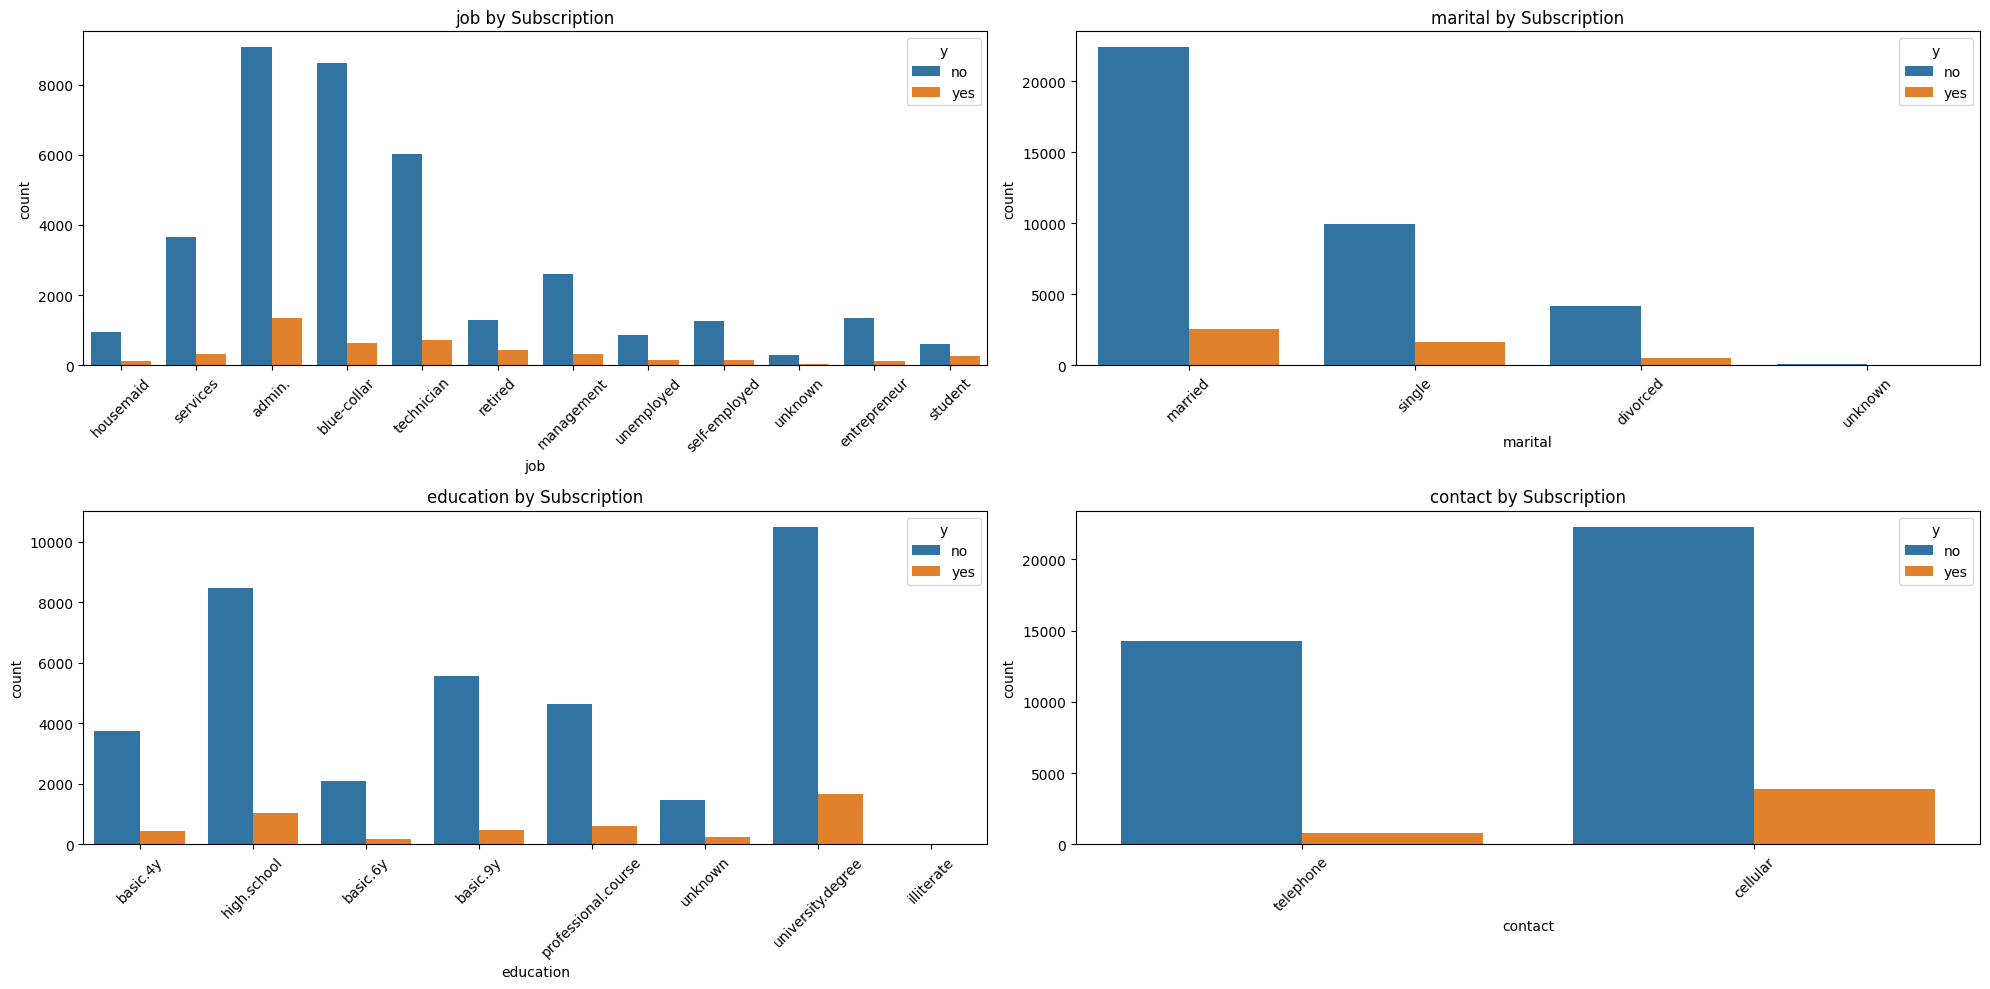

In [69]:
# Count plots for selected categorical features by target
selected_categorical = ['job', 'marital', 'education', 'contact']
plt.figure(figsize=(20, 10))
for i, col in enumerate(selected_categorical):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, hue='y', data=data)
    plt.title(f'{col} by Subscription')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
# Target distribution
print("Target Distribution:\n", data['y'].value_counts(normalize=True))

Target Distribution:
 y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


#### Visualization Analysis
- **Box Plots**: Customers who subscribed (`yes`) tend to have longer `duration` of last contact, suggesting that extended engagement may influence subscription. Features like `age` and `campaign` show overlap between classes, indicating potential complexity in separation.
- **Count Plots**: Subscription rates vary by `job` (e.g., higher among students and retirees), `marital` status (married customers dominate but have lower proportional subscription), `education`, and `contact` type (cellular contacts have more subscriptions than telephone).
- **Target Distribution**: Approximately 88.7% of customers did not subscribe (`no`), and 11.3% did (`yes`), indicating a class imbalance that may affect model performance.

### Model Building and Training

Three classification models are used to predict customer subscriptions:

- **Logistic Regression**: Linear model for binary classification.
- **Decision Tree**: Non-linear decision-based classifier.
- **Random Forest**: Ensemble of decision trees.

--- Logistic Regression ---
Accuracy: 0.911143481427531
Confusion Matrix:
 [[7104  199]
 [ 533  402]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7303
           1       0.67      0.43      0.52       935

    accuracy                           0.91      8238
   macro avg       0.80      0.70      0.74      8238
weighted avg       0.90      0.91      0.90      8238

--- Decision Tree ---
Accuracy: 0.8883224083515416
Confusion Matrix:
 [[6815  488]
 [ 432  503]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      7303
           1       0.51      0.54      0.52       935

    accuracy                           0.89      8238
   macro avg       0.72      0.74      0.73      8238
weighted avg       0.89      0.89      0.89      8238

--- Random Forest ---
Accuracy: 0.911750424860403
Confusion Matrix:
 [[7092  211]
 [ 516  419]]
Cla

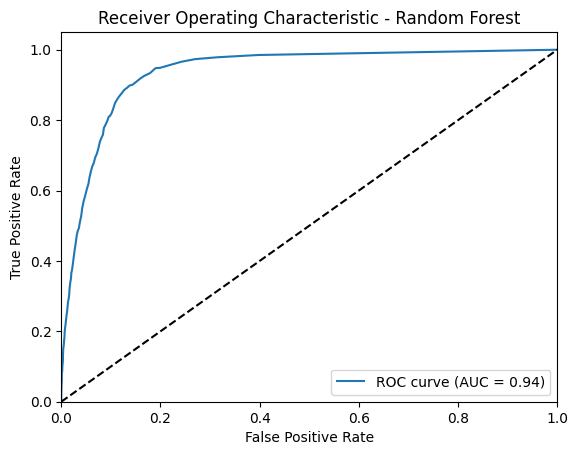

In [71]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Define and train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "y_pred": y_pred,
        "y_pred_proba": model.predict_proba(X_test)[:, 1]  # For ROC curve
    }

# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

for name, result in results.items():
    evaluate_model(y_test, result["y_pred"], name)

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, results["Random Forest"]["y_pred_proba"])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

- **Logistic Regression (Accuracy: 0.91, Recall: 0.43)**: High accuracy but struggles with minority class.  
- **Decision Tree (Accuracy: 0.89, Recall: 0.53)**: Lower accuracy, better minority class recall.  
- **Random Forest (Accuracy: 0.91, Recall: 0.46, AUC: 0.94)**: Best overall performance with strong discriminative ability.

### PCA Visualization

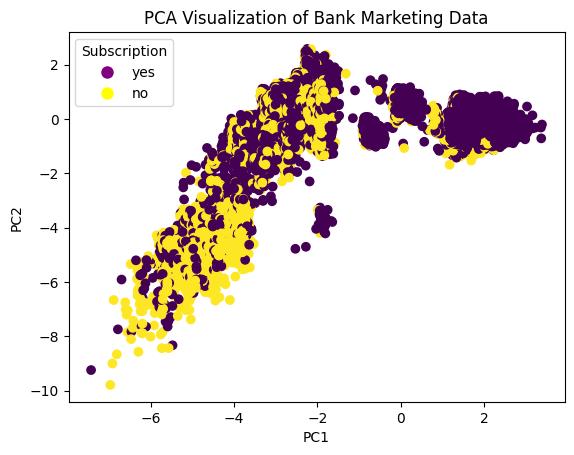

In [73]:
# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization of Bank Marketing Data')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='yes'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='no')
]
plt.legend(handles=legend_elements, title='Subscription')

plt.show()

#### Visualization Insights
The PCA plot shows some separation between classes, though overlap exists due to the high dimensionality and complexity of the data. This suggests that while linear separability is limited, non-linear models like Random Forest may perform better.

### Discussion and Analysis
Three supervised learning models were evaluated:
- **Logistic Regression**: Achieved moderate accuracy but struggled with the minority class (`yes`) due to its linear nature and the dataset’s imbalance.
- **Decision Tree**: Showed variable performance, and had overfitting on the training data, as seen in its higher recall for the minority class.
- **Random Forest**: Its ensemble approach to captured complex feature interactions resulting in the highest accuracy and a better balanced trade-off in precision and recall.

The ROC curve for Random Forest, with an AUC of 0.94, demonstrates a strong discriminative ability. Exploratory data analysis highlights that duration serves as a significant predictor, with longer call durations associated with higher subscription rates. Categorical features such as job and contact offer additional contextual insights. Because of the dataset’s imbalance, accuracy alone is insufficient as a performance metric; Recall, Precision, and F1-Scores for the minority class are essential for a balanced evaluation. Random Forest is recommended for deployment due to its superior performance.

#### What problem do you solve?
I addressed the prediction of customer subscription to a term deposit, helping the bank target likely subscribers and improve marketing efficiency.

#### What ML approach do you use?
I used supervised learning with classification algorithms (Logistic Regression, Decision Tree, Random Forest), supported by preprocessing, train-test splitting, and PCA for visualization.

### Dataset Citation
- Yamahata, H. (n.d.). *Bank Marketing*. Kaggle. Retrieved from [https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing](https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing)